In [1]:
!pip install -q segmentation_models_pytorch

In [2]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import gc
import time
from collections import defaultdict
import  matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.cuda import amp
import torch.optim as optim
import albumentations as A
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class CFG:
    seed          = 42
    debug         = False # set debug=False for Full Training
    exp_name      = 'baseline'
    comment       = 'unet-efficientnet_b1-512x512'
    output_dir    = './'
    model_name    = 'Unet'
    backbone      = 'resnext50_32x4d'
    train_bs      = 5
    valid_bs      = 5
    img_size      = [512, 512]
    epochs        = 8
    n_accumulate  = max(1, 64//train_bs)
    lr            = 1e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(2279/(train_bs*n_accumulate)*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_fold        = 5
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    gt_df = "/kaggle/input/sennet-hoa-gt-data/gt.csv"
    data_root = "/kaggle/input"
    train_groups = ["kidney_1_dense", 'kidney_2']
    valid_groups = ["kidney_3_sparse"]
    loss_func     = "DiceLoss"

    data_transforms = {
        "train": A.Compose([
            A.Resize(*img_size, interpolation=cv2.INTER_NEAREST),
            A.HorizontalFlip(p=0.5),
        ], p=1.0),
        
        "valid": A.Compose([
            A.Resize(*img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
    }

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(CFG.seed)

# DataLoader

In [5]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    return msk

In [6]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, msk_paths=[], transforms=None):
        self.img_paths  = img_paths
        self.msk_paths  = msk_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = load_img(img_path)
        
        if len(self.msk_paths)>0:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            orig_size = img.shape
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), torch.tensor(np.array([orig_size[0], orig_size[1]]))

In [7]:
train_groups = CFG.train_groups
valid_groups = CFG.valid_groups
gt_df = pd.read_csv(CFG.gt_df)
gt_df["img_path"] = gt_df["img_path"].apply(lambda x: os.path.join(CFG.data_root, x))
gt_df["msk_path"] = gt_df["msk_path"].apply(lambda x: os.path.join(CFG.data_root, x))
train_df = gt_df.query("group in @train_groups").reset_index(drop=True)
valid_df = gt_df.query("group in @valid_groups").reset_index(drop=True)
train_img_paths = train_df["img_path"].values.tolist()
train_msk_paths = train_df["msk_path"].values.tolist()
valid_img_paths = valid_df["img_path"].values.tolist()
valid_msk_paths = valid_df["msk_path"].values.tolist()
if CFG.debug:
    train_img_paths = train_img_paths[:CFG.train_bs*5]
    train_msk_paths = train_msk_paths[:CFG.train_bs*5]
    valid_img_paths = valid_img_paths[:CFG.valid_bs*3]
    valid_msk_paths = valid_msk_paths[:CFG.valid_bs*3]

In [8]:
train_dataset = BuildDataset(train_img_paths, train_msk_paths, transforms=CFG.data_transforms['train'])
valid_dataset = BuildDataset(valid_img_paths, valid_msk_paths, transforms=CFG.data_transforms['valid'])
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)

### Chack Augmentation

kidney_1_dense_0912


/tmp/ipykernel_27/2953722667.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


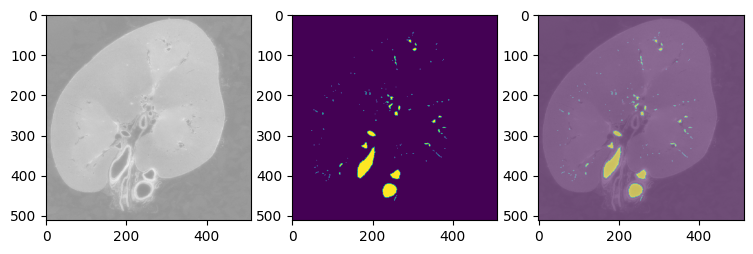

kidney_1_dense_0204


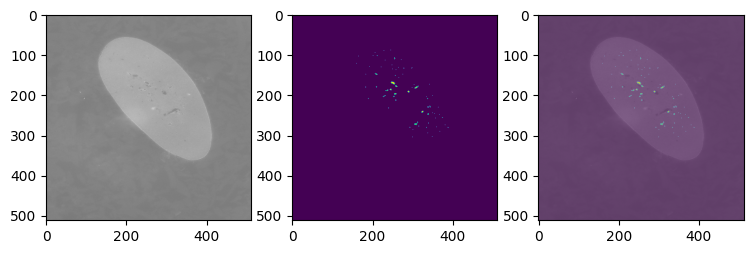

kidney_1_dense_2253


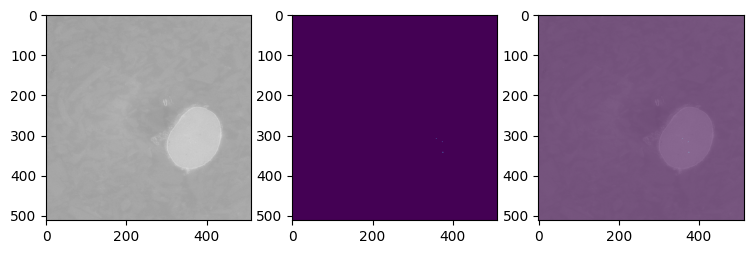

kidney_1_dense_2006


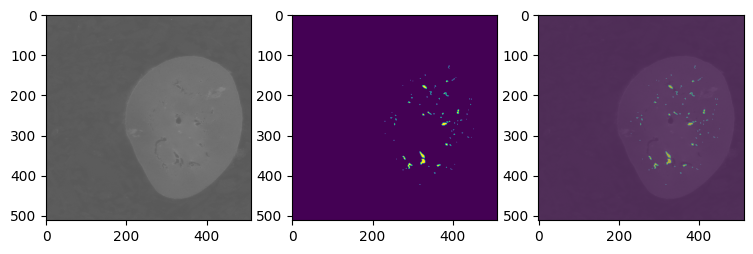

kidney_1_dense_1828


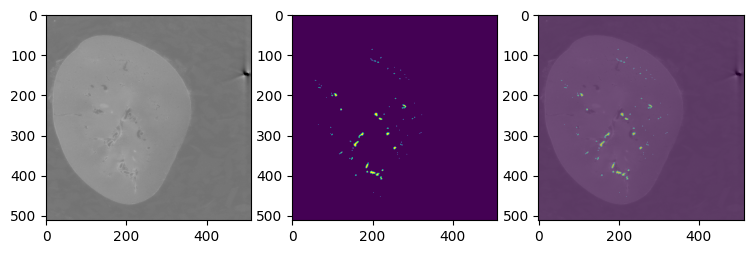

In [9]:
sample_ids = [random.randint(0, len(train_img_paths)) for _ in range(5)]
for sample_id in sample_ids:
    data_name = train_df.loc[sample_id]["id"]
    img, msk = train_dataset[sample_id]
    img = img.permute((1, 2, 0)).numpy()*255.0
    img = img.astype('uint8')
    msk = (msk*255).numpy().astype('uint8')
    plt.figure(figsize=(9, 4))
    print(data_name)
    plt.axis('off')
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(msk)
    plt.subplot(1,3,3)
    plt.imshow(img, cmap='bone')
    plt.imshow(msk, alpha=0.5)
    plt.show()

# Model

In [10]:
class attention_block(nn.Module):
    def __init__(self, F_g, F_l, n_coefficients):
        super(attention_block, self).__init__()

        self.bypass = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.upsample(gate)
        x1 = self.bypass(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out

class MyUNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                )
        return block
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
            )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=1):
            block = torch.nn.Sequential(
                    
                    torch.nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=0),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
            )
            return  block

    def __init__(self, in_channel, out_channel):
        super(MyUNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )

        # Decode
        self.attention3 = attention_block(256, 256, 128)
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.attention2 = attention_block(128, 128, 64)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.attention1 = attention_block(64, 64, 32)
        self.final_layer = self.final_block(128, 64, out_channel)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottle_neck1 = self.bottleneck(encode_pool3)
        # Decode
        att_3 = self.attention3(bottle_neck1, encode_block3) 
        decode_block1 = torch.cat((bottle_neck1, att_3), 1)
        cat_layer2 = self.conv_decode3(decode_block1)
        
        att_2 = self.attention2(cat_layer2, encode_block2) 
        decode_block2 = torch.cat((cat_layer2, att_2), 1)
        cat_layer1 = self.conv_decode2(decode_block2)
        
        
        att_1 = self.attention1(cat_layer1, encode_block1) 
        decode_block3 = torch.cat((cat_layer1, att_1), 1)
        final_layer = self.final_layer(decode_block3)
        return final_layer
def build_model(backbone, num_classes, device):
    model = MyUNet(in_channel=3, out_channel=num_classes)
    model.to(device)
    return model

In [11]:
model = build_model(CFG.backbone, CFG.num_classes, CFG.device)

# Loss Function

In [12]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = nn.BCEWithLogitsLoss()
def criterion(y_pred, y_true):
    if CFG.loss_func == "DiceLoss":
        return DiceLoss(y_pred, y_true)
    elif CFG.loss_func == "BCELoss":
        y_true = y_true.unsqueeze(1)
        return BCELoss(y_pred, y_true)

# Metrics

In [13]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

# Optimizer

In [14]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

### Check LR

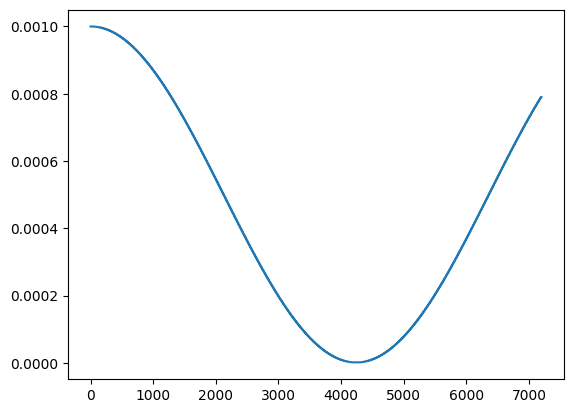

In [15]:
_optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
_scheduler = fetch_scheduler(_optimizer)
lr_list = []
for e in range(CFG.epochs):
    for step in range(len(train_loader)):
        lr_list.append(_optimizer.param_groups[0]['lr'])
        if (step + 1) % CFG.n_accumulate == 0:
            _optimizer.step()
            _scheduler.step()
plt.plot(np.array(range(len(lr_list))), np.array(lr_list))
plt.show()
del _optimizer, _scheduler

# Training Function

In [16]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix( epoch=f'{epoch}',
                          train_loss=f'{epoch_loss:0.4f}',
                          lr=f'{current_lr:0.5f}',
                          gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss

In [17]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, val_scores

In [18]:
def run_training(model, optimizer, scheduler, device, num_epochs):    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss      = np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        print(f'Valid Loss: {val_loss}')
        
        # deep copy the model
        if val_loss <= best_loss:
            print(f"{c_}Valid loss Improved ({best_loss} ---> {val_loss})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_loss = val_loss
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "best_epoch.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = "last_epoch.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Train

In [19]:
model, history = run_training(model, optimizer, scheduler,
                                device=CFG.device,
                                num_epochs=CFG.epochs)

cuda: Tesla T4

Epoch 1/8

Valid : 100%|██████████| 207/207 [04:43<00:00,  1.37s/it, gpu_memory=4.97 GB, lr=0.00089, valid_loss=0.8663]


Valid Dice: 0.3041 | Valid Jaccard: 0.1953
Valid Loss: 0.8662639870735758
Valid loss Improved (inf ---> 0.8662639870735758)
Model Saved


Epoch 2/8

Valid : 100%|██████████| 207/207 [04:39<00:00,  1.35s/it, gpu_memory=4.99 GB, lr=0.00062, valid_loss=0.8649]


Valid Dice: 0.3440 | Valid Jaccard: 0.2286
Valid Loss: 0.8649404357020981
Valid loss Improved (0.8662639870735758 ---> 0.8649404357020981)
Model Saved


Epoch 3/8

Valid : 100%|██████████| 207/207 [02:41<00:00,  1.28it/s, gpu_memory=4.99 GB, lr=0.00029, valid_loss=0.8668]


Valid Dice: 0.3189 | Valid Jaccard: 0.2150
Valid Loss: 0.8668462297190791


Epoch 4/8

Valid : 100%|██████████| 207/207 [02:39<00:00,  1.30it/s, gpu_memory=5.02 GB, lr=0.00006, valid_loss=0.8670]


Valid Dice: 0.3082 | Valid Jaccard: 0.2037
Valid Loss: 0.8669794803656242


Epoch 5/8

Valid : 100%|██████████| 207/207 [02:42<00:00,  1.27it/s, gpu_memory=4.99 GB, lr=0.00001, valid_loss=0.8668]


Valid Dice: 0.3054 | Valid Jaccard: 0.2014
Valid Loss: 0.8668175886794565


Epoch 6/8

Valid : 100%|██████████| 207/207 [02:43<00:00,  1.27it/s, gpu_memory=5.02 GB, lr=0.00018, valid_loss=0.8669]


Valid Dice: 0.3124 | Valid Jaccard: 0.2065
Valid Loss: 0.866907322752303


Epoch 7/8

Valid : 100%|██████████| 207/207 [02:42<00:00,  1.27it/s, gpu_memory=4.99 GB, lr=0.00048, valid_loss=0.8674]


Valid Dice: 0.2653 | Valid Jaccard: 0.1689
Valid Loss: 0.8674454205278037


Epoch 8/8

Valid : 100%|██████████| 207/207 [02:40<00:00,  1.29it/s, gpu_memory=5.02 GB, lr=0.00079, valid_loss=0.8672]


Valid Dice: 0.2691 | Valid Jaccard: 0.1744
Valid Loss: 0.8671907733603952


Training complete in 1h 49m 58s
Best Loss: 0.8649


# Evaluate

In [20]:
"""Surface Dice metric for HuBMAP 4."""

import numpy as np
import pandas as pd
import pandas.api.types
from numba import jit
from scipy.ndimage import label, generate_binary_structure
from skimage.transform import resize
from typing import Optional, Tuple, Union


class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    rle_column_name: str,
    tolerance: float = 1.0,
    image_id_column_name: Optional[str] = None,
    slice_id_column_name: Optional[str] = None,
    resize_fraction: float = 1.0,
) -> float:
    """Mean Surface Dice over collections of 2D or 3D data.

    This metric is adapted from the Google DeepMind surface dice metric as found here:
    https://github.com/google-deepmind/surface-distance/tree/master.

    Can be used with either 2D or 3D data. When used with 3D data, each row in the solution and
    submission files should contain run-length encoded masks of a width x height slice.

    Parameters
    ----------
    solution : Pandas dataframe, the ground truth values.

    submission : Pandas dataframe, the predicted values.

    row_id_column_name : str, the name of the ID column used by Kaggle's preprocessing code to
        align the solution and submission dataframes.

    rle_column_name : str, the name of column containing run-length encoded masks.

    tolerance : float, the distance, in millimeters, the predicted mask surfaces are allowed to
        vary from the ground-truth masks.

    image_id_column_name : str (optional), for 3D data, the name of the column identifying
        the image a slice belongs to.

    slice_id_column_name : str (optional), for 3D data, the name of the column enumerating
        the slices within each image.

    resize_fraction : float, the fraction by which to resize the decoded masks. Useful for memory
        efficiency in the case of large images.

    Returns
    -------
    mean_surface_dice : float

    Examples
    --------
    No groups (2D images).
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ...     'width': [5, 5],
    ...     'height': [5, 5],
    ... })

    Perfect submission.
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0)
    1.0

    One group with two slices.
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ...     'width': [5, 5],
    ...     'height': [5, 5],
    ...     'group': ['a', 'a'],
    ...     'slice': [0, 1],
    ... })

    Perfect submission.
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['1 12 20 2', '1 6'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    1.0

    Null submission.
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1],
    ...     'rle': ['', ''],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    0.0

    Two groups with multiple slices.
    >>> solution = pd.DataFrame({
    ...     'id': [0, 1, 2, 3, 4],
    ...     'rle': ['1 12', '1 12 ', '1 12', '20 5', '22 2'],
    ...     'width': [5, 5, 5, 8, 8],
    ...     'height': [5, 5, 5, 4, 4],
    ...     'group': ['a', 'a', 'a', 'b', 'b'],
    ...     'slice': [0, 1, 2, 0, 1],
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': [0, 1, 2, 3, 4],
    ...     'rle': ['1 12', '1 12 ', '1 12', '20 5', '22 2'],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    1.0

    >>> submission = pd.DataFrame({
    ...     'id': [0, 1, 2, 3, 4],
    ...     'rle': ['1 11', '1 12 ', '1 13', '20 4', '22 3'],
    ... })

    With non-zero tolerance.
    >>> score(solution, submission, 'id', 'rle', 5.0, 'group', 'slice')
    1.0

    Cubes, adapted from https://github.com/google-deepmind/surface-distance/blob/master/surface_distance_test.py#L307
    >>> solution = pd.DataFrame({
    ...     'id': np.arange(100),
    ...     'rle': ['1 10000' if k <= 49 else '' for k in np.arange(100)],
    ...     'width': [100] * 100,
    ...     'height': [100] * 100,
    ...     'group': ['a'] * 100,
    ...     'slice': np.arange(100),
    ... })
    >>> submission = pd.DataFrame({
    ...     'id': np.arange(100),
    ...     'rle': ['1 10000' if k <= 50 else '' for k in np.arange(100)],
    ... })
    >>> score(solution, submission, 'id', 'rle', 0.0, 'group', 'slice')
    0.750877...

    """
    solution = solution.set_index(row_id_column_name)
    submission = submission.set_index(row_id_column_name)

    # Check that both are defined or neither are
    if (image_id_column_name is None) != (slice_id_column_name is None):
        raise ValueError("If one of `image_id_column_name` or `slice_id_column_name` is given, the other must be given also.")

    if tolerance < 0.0:
        raise ValueError("`tolerance` must be non-negative.")

    # Setup spacing_mm
    if image_id_column_name is None:
        spacing_mm = (1, 1)  # (height, width)
    else:
        spacing_mm = (1, 1, 1)  # (height, width, depth)

    # Create joined dataframe to iterate over
    joined = solution.join(submission,
                           lsuffix='_sol',
                           rsuffix='_sub')

    # Compute surface dice for each group of slices and total
    total_dice = 0.0
    group_col = row_id_column_name if image_id_column_name is None else image_id_column_name
    for group, df in joined.groupby(group_col):
        # Make indexing easier
        df = df.reset_index(drop=True)

        # Check that we're stacking slices in order
        if image_id_column_name is not None:
            assert df.loc[:, slice_id_column_name].is_monotonic_increasing

        group_mask_sol, group_mask_sub = [], []
        height, width = df.loc[0, 'height'], df.loc[0, 'width']
        assert (df.loc[:, 'height'].nunique() == 1) and (df.loc[:, 'width'].nunique() == 1),\
            "Height and width must be constant within each group."

        # Decode slice RLEs to arrays
        for row in df.itertuples():
            # Mask transformation
            shape = (height, width)
            group_mask_sol.append(make_mask(row.rle_sol, shape, resize_fraction))
            group_mask_sub.append(make_mask(row.rle_sub, shape, resize_fraction))

        # Stack slices to create 3D arrays
        group_mask_sol = np.stack(group_mask_sol, axis=-1)
        assert group_mask_sol.ndim == 3
        group_mask_sub = np.stack(group_mask_sub, axis=-1)
        assert group_mask_sub.ndim == 3

        # Minimize dims: 2D or 3D
        group_mask_sol = group_mask_sol.squeeze()
        group_mask_sub = group_mask_sub.squeeze()

        # Compute surface distance
        surface_dist = compute_surface_distances(
            mask_gt=group_mask_sol,
            mask_pred=group_mask_sub,
            spacing_mm=spacing_mm,
        )
        # Compute surface dice and add to running total
        total_dice += compute_surface_dice_at_tolerance(
            surface_dist,
            tolerance_mm=tolerance,
        )

    # Compute mean from running total
    if image_id_column_name is None:
        ngroups = len(joined)
    else:
        ngroups = joined.loc[:, image_id_column_name].nunique()
    mean_surface_dice = total_dice / ngroups
    return mean_surface_dice


def make_mask(rle, shape, resize_fraction):
    if resize_fraction < 0.0 or resize_fraction > 1.0:
        raise ValueError("`resize_fraction` must be between 0.0 and 1.0, inclusive.")

    mask = rle_decode(rle, shape)
    if resize_fraction < 1.0:
        new_shape = int(shape[0] * resize_fraction), int(shape[1] * resize_fraction)
        mask = voting_resize(mask, new_shape)
    mask = mask.astype(bool)
    return mask


def voting_resize(mask, new_shape):
    interpolated_mask = resize(mask, new_shape, order=1, preserve_range=True)  # Using bilinear interpolation
    voting_mask = (interpolated_mask > 0.5).astype(np.uint8)
    return voting_mask


# Below is code from https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# Below is adapted from https://github.com/google-deepmind/surface-distance

# Copyright 2018 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# surface_distance/lookup_tables.py
"""Lookup tables used by surface distance metrics."""

import math
import numpy as np

ENCODE_NEIGHBOURHOOD_3D_KERNEL = np.array([[[128, 64], [32, 16]],
                                           [[8, 4], [2, 1]]])

# _NEIGHBOUR_CODE_TO_NORMALS is a lookup table.
# For every binary neighbour code
# (2x2x2 neighbourhood = 8 neighbours = 8 bits = 256 codes)
# it contains the surface normals of the triangles (called "surfel" for
# "surface element" in the following). The length of the normal
# vector encodes the surfel area.
#
# created using the marching_cube algorithm
# see e.g. https://en.wikipedia.org/wiki/Marching_cubes
# pylint: disable=line-too-long
_NEIGHBOUR_CODE_TO_NORMALS = [[[0, 0, 0]], [[0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]], [[-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]], [[0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.125, 0.125, 0.125], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25]],
                              [[-0.125, 0.125, 0.125], [-0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[-0.375, -0.375, 0.375], [0.25, -0.25, 0.0],
                               [0.0, 0.25, 0.25], [-0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.375, -0.375, 0.375], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.25, 0.25], [-0.125, 0.125, 0.125],
                               [-0.25, 0.25, 0.25], [0.125, -0.125, -0.125]],
                              [[0.5, 0.0, -0.0], [0.25, -0.25, -0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125], [0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, 0.25], [0.0, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [0.0, 0.25, 0.25], [0.0, 0.25, 0.25]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.0, -0.25, 0.25],
                               [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.25, 0.0, 0.25], [-0.375, -0.375, 0.375],
                               [-0.25, 0.25, 0.0], [-0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25],
                               [0.25, 0.0, 0.25], [0.25, 0.0, 0.25]],
                              [[-0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.25, 0.25, 0.25],
                               [0.0, 0.0, 0.5]],
                              [[0.125, 0.125, 0.125], [0.125, 0.125, 0.125],
                               [0.25, 0.25, 0.25], [0.0, 0.0, 0.5]],
                              [[-0.0, 0.0, 0.5], [0.0, 0.0, 0.5]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.0, -0.25], [-0.375, 0.375, 0.375],
                               [-0.25, -0.25, 0.0], [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [0.25, 0.0, -0.25]],
                              [[-0.0, 0.0, 0.5], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [0.25, 0.0, -0.25]],
                              [[0.5, 0.0, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, -0.25], [0.375, -0.375, -0.375],
                               [0.0, 0.25, -0.25], [-0.125, 0.125, 0.125]],
                              [[-0.25, 0.25, -0.25], [-0.25, 0.25, -0.25],
                               [-0.125, 0.125, -0.125],
                               [-0.125, 0.125, -0.125]],
                              [[-0.0, 0.5, 0.0], [-0.25, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.25, 0.0, 0.25],
                               [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [-0.125, 0.125,
                                                         0.125]],
                              [[0.375, -0.375, 0.375], [0.0, -0.25, -0.25],
                               [-0.125, 0.125, -0.125], [0.25, 0.25, 0.0]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.0, 0.5], [0.25, -0.25, 0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.0, -0.25, 0.25], [0.0, -0.25, 0.25]],
                              [[-0.125, -0.125, 0.125], [-0.25, -0.25, 0.0],
                               [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [-0.125, -0.125, 0.125]],
                              [[-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [-0.25, -0.25, 0.0],
                               [-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.375, 0.375, -0.375], [-0.25, -0.25, 0.0],
                               [-0.125, 0.125, -0.125], [-0.25, 0.0, 0.25]],
                              [[0.0, 0.5, 0.0], [0.25, 0.25, -0.25],
                               [-0.125, -0.125, 0.125],
                               [-0.125, -0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.25, -0.25, 0.0],
                               [-0.25, 0.25, 0.0]],
                              [[0.0, -0.5, 0.0], [-0.25, -0.25, -0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, 0.125, 0.125], [0.0, -0.5, 0.0],
                               [-0.25, -0.25, -0.25], [-0.125, -0.125,
                                                       -0.125]],
                              [[-0.375, -0.375, -0.375], [-0.25, 0.0, 0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0],
                               [0.125, -0.125, 0.125]],
                              [[0.0, 0.5, 0.0], [0.0, -0.5, 0.0]],
                              [[0.0, 0.5, 0.0], [0.125, -0.125, 0.125],
                               [-0.25, 0.25, -0.25]],
                              [[0.0, 0.5, 0.0], [-0.25, 0.25, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [-0.25, 0.25, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.0, 0.25, -0.25], [0.375, -0.375, -0.375],
                               [-0.125, 0.125, 0.125], [0.25, 0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125], [0.125, -0.125,
                                                         0.125]],
                              [[0.125, -0.125, 0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.25, 0.25, -0.25], [0.25, 0.25, -0.25],
                               [0.125, 0.125, -0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.0, 0.0, 0.5], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[-0.375, -0.375, 0.375], [-0.0, 0.25, 0.25],
                               [0.125, 0.125, -0.125], [-0.25, -0.0, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25],
                               [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.25, -0.0, -0.25],
                               [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.0, -0.5, 0.0], [0.125, 0.125, -0.125],
                               [0.25, 0.25, -0.25]],
                              [[0.0, -0.25, 0.25], [0.0, 0.25, -0.25]],
                              [[0.125, 0.125, 0.125], [0.125, -0.125, 0.125]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25]],
                              [[-0.5, 0.0, 0.0], [-0.125, -0.125, -0.125],
                               [-0.25, -0.25, -0.25], [0.125, 0.125, 0.125]],
                              [[0.375, 0.375, 0.375], [0.0, 0.25, -0.25],
                               [-0.125, -0.125, -0.125], [-0.25, 0.25, 0.0]],
                              [[0.125, -0.125, -0.125], [0.25, -0.25, 0.0],
                               [0.25, -0.25, 0.0]],
                              [[0.125, 0.125, 0.125], [0.375, 0.375, 0.375],
                               [0.0, -0.25, 0.25], [-0.25, 0.0, 0.25]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[-0.125, -0.125, -0.125], [-0.25, -0.25, -0.25],
                               [0.25, 0.25, 0.25], [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125], [0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, 0.0, -0.5], [0.25, 0.25, 0.25],
                               [-0.125, -0.125, -0.125]],
                              [[0.125, -0.125, 0.125], [0.125, -0.125,
                                                        -0.125]],
                              [[0.0, -0.5, 0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[-0.125, -0.125, 0.125],
                               [0.125, -0.125, -0.125]],
                              [[0.0, -0.25, -0.25], [0.0, 0.25, 0.25]],
                              [[0.125, -0.125, -0.125]],
                              [[0.5, 0.0, 0.0], [0.5, 0.0, 0.0]],
                              [[-0.5, 0.0, 0.0], [-0.25, 0.25, 0.25],
                               [-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, 0.0], [0.25, -0.25, 0.25],
                               [-0.125, 0.125, -0.125]],
                              [[0.25, -0.25, 0.0], [0.25, -0.25, 0.0]],
                              [[0.5, 0.0, 0.0], [-0.25, -0.25, 0.25],
                               [-0.125, -0.125, 0.125]],
                              [[-0.25, 0.0, 0.25], [-0.25, 0.0, 0.25]],
                              [[0.125, 0.125, 0.125], [-0.125, 0.125, 0.125]],
                              [[-0.125, 0.125, 0.125]],
                              [[0.5, 0.0, -0.0], [0.25, 0.25, 0.25],
                               [0.125, 0.125, 0.125]],
                              [[0.125, -0.125, 0.125], [-0.125, -0.125,
                                                        0.125]],
                              [[-0.25, -0.0, -0.25], [0.25, 0.0, 0.25]],
                              [[0.125, -0.125, 0.125]],
                              [[-0.25, -0.25, 0.0], [0.25, 0.25, -0.0]],
                              [[-0.125, -0.125, 0.125]],
                              [[0.125, 0.125, 0.125]], [[0, 0, 0]]]
# pylint: enable=line-too-long


def create_table_neighbour_code_to_surface_area(spacing_mm):
    """Returns an array mapping neighbourhood code to the surface elements area.

  Note that the normals encode the initial surface area. This function computes
  the area corresponding to the given `spacing_mm`.

  Args:
    spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2
      direction.
  """
    # compute the area for all 256 possible surface elements
    # (given a 2x2x2 neighbourhood) according to the spacing_mm
    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(_NEIGHBOUR_CODE_TO_NORMALS[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    return neighbour_code_to_surface_area


# In the neighbourhood, points are ordered: top left, top right, bottom left,
# bottom right.
ENCODE_NEIGHBOURHOOD_2D_KERNEL = np.array([[8, 4], [2, 1]])


def create_table_neighbour_code_to_contour_length(spacing_mm):
    """Returns an array mapping neighbourhood code to the contour length.

  For the list of possible cases and their figures, see page 38 from:
  https://nccastaff.bournemouth.ac.uk/jmacey/MastersProjects/MSc14/06/thesis.pdf

  In 2D, each point has 4 neighbors. Thus, are 16 configurations. A
  configuration is encoded with '1' meaning "inside the object" and '0' "outside
  the object". The points are ordered: top left, top right, bottom left, bottom
  right.

  The x0 axis is assumed vertical downward, and the x1 axis is horizontal to the
  right:
   (0, 0) --> (0, 1)
     |
   (1, 0)

  Args:
    spacing_mm: 2-element list-like structure. Voxel spacing in x0 and x1
      directions.
  """
    neighbour_code_to_contour_length = np.zeros([16])

    vertical = spacing_mm[0]
    horizontal = spacing_mm[1]
    diag = 0.5 * math.sqrt(spacing_mm[0]**2 + spacing_mm[1]**2)
    # pyformat: disable
    neighbour_code_to_contour_length[int("00" "01", 2)] = diag

    neighbour_code_to_contour_length[int("00" "10", 2)] = diag

    neighbour_code_to_contour_length[int("00" "11", 2)] = horizontal

    neighbour_code_to_contour_length[int("01" "00", 2)] = diag

    neighbour_code_to_contour_length[int("01" "01", 2)] = vertical

    neighbour_code_to_contour_length[int("01" "10", 2)] = 2 * diag

    neighbour_code_to_contour_length[int("01" "11", 2)] = diag

    neighbour_code_to_contour_length[int("10" "00", 2)] = diag

    neighbour_code_to_contour_length[int("10" "01", 2)] = 2 * diag

    neighbour_code_to_contour_length[int("10" "10", 2)] = vertical

    neighbour_code_to_contour_length[int("10" "11", 2)] = diag

    neighbour_code_to_contour_length[int("11" "00", 2)] = horizontal

    neighbour_code_to_contour_length[int("11" "01", 2)] = diag

    neighbour_code_to_contour_length[int("11" "10", 2)] = diag
    # pyformat: enable

    return neighbour_code_to_contour_length


# surface_distance/metrics.py
"""Module exposing surface distance based measures."""

import numpy as np
from scipy import ndimage


def _assert_is_numpy_array(name, array):
    """Raises an exception if `array` is not a numpy array."""
    if not isinstance(array, np.ndarray):
        raise ValueError("The argument {!r} should be a numpy array, not a "
                         "{}".format(name, type(array)))


def _check_nd_numpy_array(name, array, num_dims):
    """Raises an exception if `array` is not a `num_dims`-D numpy array."""
    if len(array.shape) != num_dims:
        raise ValueError("The argument {!r} should be a {}D array, not of "
                         "shape {}".format(name, num_dims, array.shape))


def _check_2d_numpy_array(name, array):
    _check_nd_numpy_array(name, array, num_dims=2)


def _check_3d_numpy_array(name, array):
    _check_nd_numpy_array(name, array, num_dims=3)


def _assert_is_bool_numpy_array(name, array):
    _assert_is_numpy_array(name, array)
    if array.dtype != bool:
        raise ValueError(
            "The argument {!r} should be a numpy array of type bool, "
            "not {}".format(name, array.dtype))


def _compute_bounding_box(mask):
    """Computes the bounding box of the masks.

  This function generalizes to arbitrary number of dimensions great or equal
  to 1.

  Args:
    mask: The 2D or 3D numpy mask, where '0' means background and non-zero means
      foreground.

  Returns:
    A tuple:
     - The coordinates of the first point of the bounding box (smallest on all
       axes), or `None` if the mask contains only zeros.
     - The coordinates of the second point of the bounding box (greatest on all
       axes), or `None` if the mask contains only zeros.
  """
    num_dims = len(mask.shape)
    bbox_min = np.zeros(num_dims, np.int64)
    bbox_max = np.zeros(num_dims, np.int64)

    # max projection to the x0-axis
    proj_0 = np.amax(mask, axis=tuple(range(num_dims))[1:])
    idx_nonzero_0 = np.nonzero(proj_0)[0]
    if len(idx_nonzero_0) == 0:  # pylint: disable=g-explicit-length-test
        return None, None

    bbox_min[0] = np.min(idx_nonzero_0)
    bbox_max[0] = np.max(idx_nonzero_0)

    # max projection to the i-th-axis for i in {1, ..., num_dims - 1}
    for axis in range(1, num_dims):
        max_over_axes = list(range(num_dims))  # Python 3 compatible
        max_over_axes.pop(axis)  # Remove the i-th dimension from the max
        max_over_axes = tuple(max_over_axes)  # numpy expects a tuple of ints
        proj = np.amax(mask, axis=max_over_axes)
        idx_nonzero = np.nonzero(proj)[0]
        bbox_min[axis] = np.min(idx_nonzero)
        bbox_max[axis] = np.max(idx_nonzero)

    return bbox_min, bbox_max


def _crop_to_bounding_box(mask, bbox_min, bbox_max):
    """Crops a 2D or 3D mask to the bounding box specified by `bbox_{min,max}`."""
    # we need to zeropad the cropped region with 1 voxel at the lower,
    # the right (and the back on 3D) sides. This is required to obtain the
    # "full" convolution result with the 2x2 (or 2x2x2 in 3D) kernel.
    # TODO:  This is correct only if the object is interior to the
    # bounding box.
    cropmask = np.zeros((bbox_max - bbox_min) + 2, np.uint8)

    num_dims = len(mask.shape)
    # pyformat: disable
    if num_dims == 2:
        cropmask[0:-1, 0:-1] = mask[bbox_min[0]:bbox_max[0] + 1,
                                    bbox_min[1]:bbox_max[1] + 1]
    elif num_dims == 3:
        cropmask[0:-1, 0:-1, 0:-1] = mask[bbox_min[0]:bbox_max[0] + 1,
                                          bbox_min[1]:bbox_max[1] + 1,
                                          bbox_min[2]:bbox_max[2] + 1]
    # pyformat: enable
    else:
        assert False

    return cropmask


def _sort_distances_surfels(distances, surfel_areas):
    """Sorts the two list with respect to the tuple of (distance, surfel_area).

  Args:
    distances: The distances from A to B (e.g. `distances_gt_to_pred`).
    surfel_areas: The surfel areas for A (e.g. `surfel_areas_gt`).

  Returns:
    A tuple of the sorted (distances, surfel_areas).
  """
    sorted_surfels = np.array(sorted(zip(distances, surfel_areas)))
    return sorted_surfels[:, 0], sorted_surfels[:, 1]


def compute_surface_distances(mask_gt, mask_pred, spacing_mm):
    """Computes closest distances from all surface points to the other surface.

  This function can be applied to 2D or 3D tensors. For 2D, both masks must be
  2D and `spacing_mm` must be a 2-element list. For 3D, both masks must be 3D
  and `spacing_mm` must be a 3-element list. The description is done for the 2D
  case, and the formulation for the 3D case is present is parenthesis,
  introduced by "resp.".

  Finds all contour elements (resp surface elements "surfels" in 3D) in the
  ground truth mask `mask_gt` and the predicted mask `mask_pred`, computes their
  length in mm (resp. area in mm^2) and the distance to the closest point on the
  other contour (resp. surface). It returns two sorted lists of distances
  together with the corresponding contour lengths (resp. surfel areas). If one
  of the masks is empty, the corresponding lists are empty and all distances in
  the other list are `inf`.

  Args:
    mask_gt: 2-dim (resp. 3-dim) bool Numpy array. The ground truth mask.
    mask_pred: 2-dim (resp. 3-dim) bool Numpy array. The predicted mask.
    spacing_mm: 2-element (resp. 3-element) list-like structure. Voxel spacing
      in x0 anx x1 (resp. x0, x1 and x2) directions.

  Returns:
    A dict with:
    "distances_gt_to_pred": 1-dim numpy array of type float. The distances in mm
        from all ground truth surface elements to the predicted surface,
        sorted from smallest to largest.
    "distances_pred_to_gt": 1-dim numpy array of type float. The distances in mm
        from all predicted surface elements to the ground truth surface,
        sorted from smallest to largest.
    "surfel_areas_gt": 1-dim numpy array of type float. The length of the
      of the ground truth contours in mm (resp. the surface elements area in
      mm^2) in the same order as distances_gt_to_pred.
    "surfel_areas_pred": 1-dim numpy array of type float. The length of the
      of the predicted contours in mm (resp. the surface elements area in
      mm^2) in the same order as distances_gt_to_pred.

  Raises:
    ValueError: If the masks and the `spacing_mm` arguments are of incompatible
      shape or type. Or if the masks are not 2D or 3D.
  """
    # The terms used in this function are for the 3D case. In particular, surface
    # in 2D stands for contours in 3D. The surface elements in 3D correspond to
    # the line elements in 2D.

    _assert_is_bool_numpy_array("mask_gt", mask_gt)
    _assert_is_bool_numpy_array("mask_pred", mask_pred)

    if not len(mask_gt.shape) == len(mask_pred.shape) == len(spacing_mm):
        raise ValueError(
            "The arguments must be of compatible shape. Got mask_gt "
            "with {} dimensions ({}) and mask_pred with {} dimensions "
            "({}), while the spacing_mm was {} elements.".format(
                len(mask_gt.shape), mask_gt.shape, len(mask_pred.shape),
                mask_pred.shape, len(spacing_mm)))

    num_dims = len(spacing_mm)
    if num_dims == 2:
        _check_2d_numpy_array("mask_gt", mask_gt)
        _check_2d_numpy_array("mask_pred", mask_pred)

        # compute the area for all 16 possible surface elements
        # (given a 2x2 neighbourhood) according to the spacing_mm
        neighbour_code_to_surface_area = (
            create_table_neighbour_code_to_contour_length(spacing_mm))
        kernel = ENCODE_NEIGHBOURHOOD_2D_KERNEL
        full_true_neighbours = 0b1111
    elif num_dims == 3:
        _check_3d_numpy_array("mask_gt", mask_gt)
        _check_3d_numpy_array("mask_pred", mask_pred)

        # compute the area for all 256 possible surface elements
        # (given a 2x2x2 neighbourhood) according to the spacing_mm
        neighbour_code_to_surface_area = (
            create_table_neighbour_code_to_surface_area(spacing_mm))
        kernel = ENCODE_NEIGHBOURHOOD_3D_KERNEL
        full_true_neighbours = 0b11111111
    else:
        raise ValueError("Only 2D and 3D masks are supported, not "
                         "{}D.".format(num_dims))

    # compute the bounding box of the masks to trim the volume to the smallest
    # possible processing subvolume
    bbox_min, bbox_max = _compute_bounding_box(mask_gt | mask_pred)
    # Both the min/max bbox are None at the same time, so we only check one.
    if bbox_min is None:
        return {
            "distances_gt_to_pred": np.array([]),
            "distances_pred_to_gt": np.array([]),
            "surfel_areas_gt": np.array([]),
            "surfel_areas_pred": np.array([]),
        }

    # crop the processing subvolume.
    cropmask_gt = _crop_to_bounding_box(mask_gt, bbox_min, bbox_max)
    cropmask_pred = _crop_to_bounding_box(mask_pred, bbox_min, bbox_max)

    # compute the neighbour code (local binary pattern) for each voxel
    # the resulting arrays are spacially shifted by minus half a voxel in each
    # axis.
    # i.e. the points are located at the corners of the original voxels
    neighbour_code_map_gt = ndimage.correlate(cropmask_gt.astype(np.uint8),
                                              kernel,
                                              mode="constant",
                                              cval=0)
    neighbour_code_map_pred = ndimage.correlate(cropmask_pred.astype(np.uint8),
                                                kernel,
                                                mode="constant",
                                                cval=0)

    # create masks with the surface voxels
    borders_gt = ((neighbour_code_map_gt != 0) &
                  (neighbour_code_map_gt != full_true_neighbours))
    borders_pred = ((neighbour_code_map_pred != 0) &
                    (neighbour_code_map_pred != full_true_neighbours))

    # compute the distance transform (closest distance of each voxel to the
    # surface voxels)
    if borders_gt.any():
        distmap_gt = distance_transform_edt(~borders_gt)

    else:
        distmap_gt = np.Inf * np.ones(borders_gt.shape)

    distances_pred_to_gt = distmap_gt[borders_pred]
    del distmap_gt

    if borders_pred.any():
        distmap_pred = distance_transform_edt(~borders_pred)

    else:
        distmap_pred = np.Inf * np.ones(borders_pred.shape)

    distances_gt_to_pred = distmap_pred[borders_gt]
    del distmap_pred

    # compute the area of each surface element
    surface_area_map_gt = neighbour_code_to_surface_area[neighbour_code_map_gt]
    surfel_areas_gt = surface_area_map_gt[borders_gt]
    del neighbour_code_map_gt, surface_area_map_gt, borders_gt

    surface_area_map_pred = neighbour_code_to_surface_area[neighbour_code_map_pred]
    surfel_areas_pred = surface_area_map_pred[borders_pred]
    del neighbour_code_map_pred, surface_area_map_pred, borders_pred

    # sort them by distance
    if distances_gt_to_pred.shape != (0, ):
        distances_gt_to_pred, surfel_areas_gt = _sort_distances_surfels(
            distances_gt_to_pred, surfel_areas_gt)

    if distances_pred_to_gt.shape != (0, ):
        distances_pred_to_gt, surfel_areas_pred = _sort_distances_surfels(
            distances_pred_to_gt, surfel_areas_pred)

    return {
        "distances_gt_to_pred": distances_gt_to_pred,
        "distances_pred_to_gt": distances_pred_to_gt,
        "surfel_areas_gt": surfel_areas_gt,
        "surfel_areas_pred": surfel_areas_pred,
    }


def compute_average_surface_distance(surface_distances):
    """Returns the average surface distance.

  Computes the average surface distances by correctly taking the area of each
  surface element into account. Call compute_surface_distances(...) before, to
  obtain the `surface_distances` dict.

  Args:
    surface_distances: dict with "distances_gt_to_pred", "distances_pred_to_gt"
    "surfel_areas_gt", "surfel_areas_pred" created by
    compute_surface_distances()

  Returns:
    A tuple with two float values:
      - the average distance (in mm) from the ground truth surface to the
        predicted surface
      - the average distance from the predicted surface to the ground truth
        surface.
  """
    distances_gt_to_pred = surface_distances["distances_gt_to_pred"]
    distances_pred_to_gt = surface_distances["distances_pred_to_gt"]
    surfel_areas_gt = surface_distances["surfel_areas_gt"]
    surfel_areas_pred = surface_distances["surfel_areas_pred"]
    average_distance_gt_to_pred = (
        np.sum(distances_gt_to_pred * surfel_areas_gt) /
        np.sum(surfel_areas_gt))
    average_distance_pred_to_gt = (
        np.sum(distances_pred_to_gt * surfel_areas_pred) /
        np.sum(surfel_areas_pred))
    return (average_distance_gt_to_pred, average_distance_pred_to_gt)


def compute_robust_hausdorff(surface_distances, percent):
    """Computes the robust Hausdorff distance.

  Computes the robust Hausdorff distance. "Robust", because it uses the
  `percent` percentile of the distances instead of the maximum distance. The
  percentage is computed by correctly taking the area of each surface element
  into account.

  Args:
    surface_distances: dict with "distances_gt_to_pred", "distances_pred_to_gt"
      "surfel_areas_gt", "surfel_areas_pred" created by
      compute_surface_distances()
    percent: a float value between 0 and 100.

  Returns:
    a float value. The robust Hausdorff distance in mm.
  """
    distances_gt_to_pred = surface_distances["distances_gt_to_pred"]
    distances_pred_to_gt = surface_distances["distances_pred_to_gt"]
    surfel_areas_gt = surface_distances["surfel_areas_gt"]
    surfel_areas_pred = surface_distances["surfel_areas_pred"]
    if len(distances_gt_to_pred) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_gt = np.cumsum(surfel_areas_gt) / np.sum(
            surfel_areas_gt)
        idx = np.searchsorted(surfel_areas_cum_gt, percent / 100.0)
        perc_distance_gt_to_pred = distances_gt_to_pred[min(
            idx,
            len(distances_gt_to_pred) - 1)]
    else:
        perc_distance_gt_to_pred = np.Inf

    if len(distances_pred_to_gt) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_pred = (np.cumsum(surfel_areas_pred) /
                                 np.sum(surfel_areas_pred))
        idx = np.searchsorted(surfel_areas_cum_pred, percent / 100.0)
        perc_distance_pred_to_gt = distances_pred_to_gt[min(
            idx,
            len(distances_pred_to_gt) - 1)]
    else:
        perc_distance_pred_to_gt = np.Inf

    return max(perc_distance_gt_to_pred, perc_distance_pred_to_gt)


def compute_surface_overlap_at_tolerance(surface_distances, tolerance_mm):
    """Computes the overlap of the surfaces at a specified tolerance.

  Computes the overlap of the ground truth surface with the predicted surface
  and vice versa allowing a specified tolerance (maximum surface-to-surface
  distance that is regarded as overlapping). The overlapping fraction is
  computed by correctly taking the area of each surface element into account.

  Args:
    surface_distances: dict with "distances_gt_to_pred", "distances_pred_to_gt"
      "surfel_areas_gt", "surfel_areas_pred" created by
      compute_surface_distances()
    tolerance_mm: a float value. The tolerance in mm

  Returns:
    A tuple of two float values. The overlap fraction in [0.0, 1.0] of the
    ground truth surface with the predicted surface and vice versa.
  """
    distances_gt_to_pred = surface_distances["distances_gt_to_pred"]
    distances_pred_to_gt = surface_distances["distances_pred_to_gt"]
    surfel_areas_gt = surface_distances["surfel_areas_gt"]
    surfel_areas_pred = surface_distances["surfel_areas_pred"]
    rel_overlap_gt = (
        np.sum(surfel_areas_gt[distances_gt_to_pred <= tolerance_mm]) /
        np.sum(surfel_areas_gt))
    rel_overlap_pred = (
        np.sum(surfel_areas_pred[distances_pred_to_gt <= tolerance_mm]) /
        np.sum(surfel_areas_pred))
    return (rel_overlap_gt, rel_overlap_pred)


def compute_surface_dice_at_tolerance(surface_distances, tolerance_mm):
    """Computes the _surface_ DICE coefficient at a specified tolerance.

  Computes the _surface_ DICE coefficient at a specified tolerance. Not to be
  confused with the standard _volumetric_ DICE coefficient. The surface DICE
  measures the overlap of two surfaces instead of two volumes. A surface
  element is counted as overlapping (or touching), when the closest distance to
  the other surface is less or equal to the specified tolerance. The DICE
  coefficient is in the range between 0.0 (no overlap) to 1.0 (perfect overlap).

  Args:
    surface_distances: dict with "distances_gt_to_pred", "distances_pred_to_gt"
      "surfel_areas_gt", "surfel_areas_pred" created by
      compute_surface_distances()
    tolerance_mm: a float value. The tolerance in mm

  Returns:
    A float value. The surface DICE coefficient in [0.0, 1.0].
  """
    distances_gt_to_pred = surface_distances["distances_gt_to_pred"]
    distances_pred_to_gt = surface_distances["distances_pred_to_gt"]
    surfel_areas_gt = surface_distances["surfel_areas_gt"]
    surfel_areas_pred = surface_distances["surfel_areas_pred"]
    overlap_gt = np.sum(surfel_areas_gt[distances_gt_to_pred <= tolerance_mm])
    overlap_pred = np.sum(
        surfel_areas_pred[distances_pred_to_gt <= tolerance_mm])
    surface_dice = (overlap_gt + overlap_pred) / (np.sum(surfel_areas_gt) +
                                                  np.sum(surfel_areas_pred))
    return surface_dice


def compute_dice_coefficient(mask_gt, mask_pred):
    """Computes soerensen-dice coefficient.

  compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
  and the predicted mask `mask_pred`.

  Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.

  Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
  """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.NaN
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2 * volume_intersect / volume_sum


# Below is from https://github.com/Image-Py/imagepy/blob/master/imagepy/ipyalg/hydrology/edt.py
# Copyright (c) <2016>, <ImagePy>
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
# 1. Redistributions of source code must retain the above copyright
#    notice, this list of conditions and the following disclaimer.
# 2. Redistributions in binary form must reproduce the above copyright
#    notice, this list of conditions and the following disclaimer in the
#    documentation and/or other materials provided with the distribution.
# 3. All advertising materials mentioning features or use of this software
#    must display the following acknowledgement:
#    This product includes software developed by the <organization>.
# 4. Neither the name of the <organization> nor the
#    names of its contributors may be used to endorse or promote products
#    derived from this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY <ImagePy> ''AS IS'' AND ANY
# EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL <ImagePy> BE LIABLE FOR ANY
# DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

def neighbors(shape):
    dim = len(shape)
    block = generate_binary_structure(dim, 1)
    block[tuple([1]*dim)] = 0
    idx = np.where(block>0)
    idx = np.array(idx, dtype=np.uint8).T
    idx = np.array(idx-[1]*dim)
    acc = np.cumprod((1,)+shape[::-1][:-1])
    return np.dot(idx, acc[::-1])


@jit(nopython=True)
def dist(idx1, idx2, acc):
    dis = 0
    for i in range(len(acc)):
        c1 = idx1//acc[i]
        c2 = idx2//acc[i]
        dis += (c1-c2)**2
        idx1 -= c1*acc[i]
        idx2 -= c2*acc[i]
    return dis


@jit(nopython=True)
def _step(dis, pts, roots, s, level, nbs, acc, scale):
    cur = 0
    while cur<s:
        p = pts[cur]
        rp = roots[cur]
        if dis[p] == 0xffff or dis[p]>level:
            cur += 1
            continue
        for dp in nbs:
            cp = p+dp
            if dis[cp]<level*scale+2e-10:continue
            if dis[cp]==0xffff:continue
            tdist = dist(cp, rp, acc)
            if tdist<dis[cp]**2-1e-10:
                dis[cp] = (tdist**0.5)*scale
                pts[s] = cp
                roots[s] = rp
                if s == len(pts):
                    s, cur = clear(pts, roots, s, cur)
                s+=1
        pts[cur] = -1
        cur+=1
    return cur


@jit(nopython=True)
def clear(pts, roots, s, cur):
    ns = 0; nc=0;
    for c in range(s):
        if pts[c]!=-1:
            pts[ns] = pts[c]
            roots[ns] = roots[c]
            ns += 1
            if c<cur:nc += 1
    return ns, nc

        
@jit(nopython=True)
def collect(dis, nbs, pts, root):
    cur = 0
    for p in range(len(dis)):
        if dis[p]>=0xffff-1: continue # edge or back
        for dp in nbs:
            if dis[p+dp]==0xffff-1:
                pts[cur] = p
                root[cur] = p
                cur += 1
                break
    return cur


@jit(nopython=True)
def bufjit(line):
    for i in range(len(line)):
        line[i] = 1 if line[i]==0 else 0xffff


def buffer(img, dtype):
    buf = np.ones(tuple(np.array(img.shape)+2), dtype=dtype)
    buf[tuple([slice(1,-1)]*buf.ndim)] = img
    bufjit(buf.ravel())
    buf[tuple([slice(1,-1)]*buf.ndim)] -= 1
    return buf


def distance_transform_edt(img, output=np.float32, scale=1):
    dis = buffer(img, output)
    nbs = neighbors(dis.shape)
    acc = np.cumprod((1,)+dis.shape[::-1][:-1])[::-1]
    line = dis.ravel()
    pts = np.zeros(max(line.size//4, 1024**2), dtype=np.int64)
    roots = np.zeros(max(line.size//4, 1024**2), dtype=np.int64)
    s = collect(line, nbs, pts, roots)
    for level in range(10000):
        s, c = clear(pts, roots, s, 0)
        s = _step(line, pts, roots, s, level, nbs, acc, scale)
        if s==0:break
    return dis[(slice(1,-1),)*img.ndim]

In [21]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle=='':
        rle = '1 0'
    return rle

In [22]:
test_dataset = BuildDataset(valid_img_paths, [], transforms=CFG.data_transforms['valid'])
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True)

In [23]:
### Inference
rles = []
pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
for step, (images, shapes) in pbar:
    shapes = shapes.numpy()
    images = images.to(CFG.device, dtype=torch.float)
    with torch.no_grad():
        preds = model(images)
        preds = (nn.Sigmoid()(preds)>0.5).double()
    preds = preds.cpu().numpy().astype(np.uint8)

    for pred, shape in zip(preds, shapes):
        pred = cv2.resize(pred[0], (shape[1], shape[0]), cv2.INTER_NEAREST)
        rle = rle_encode(pred)
        rles.append(rle)

Inference : 100%|██████████| 207/207 [02:40<00:00,  1.29it/s]


In [24]:
ids = [f'{p.split("/")[-3]}_{os.path.basename(p).split(".")[0]}' for p in valid_img_paths]
submission = pd.DataFrame.from_dict({
    "id": ids,
    "rle": rles
})
submission.head()

,id,rle
0,kidney_3_sparse_0000,10 2 1520 3 3030 2 876967 4 878476 6 879987 4 ...
1,kidney_3_sparse_0001,10 2 28 2 34 2 40 2 46 2 52 1 58 1 64 1 69 2 7...
2,kidney_3_sparse_0002,10 2 28 2 34 2 40 2 46 2 52 1 58 1 64 1 69 2 7...
3,kidney_3_sparse_0003,10 2 28 2 34 2 40 2 46 2 52 1 58 1 64 1 69 2 7...
4,kidney_3_sparse_0004,10 2 28 2 34 2 40 2 46 2 52 1 58 161 223 7 235...


In [25]:
_gt_df = pd.merge(gt_df, submission.loc[:, ["id"]], on="id").reset_index(drop=True)
_gt_df

,id,rle,group,slice,height,width,img_path,msk_path
0,kidney_3_sparse_0000,1 0,kidney_3_sparse,0,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
1,kidney_3_sparse_0001,1 0,kidney_3_sparse,1,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
2,kidney_3_sparse_0002,1 0,kidney_3_sparse,2,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
3,kidney_3_sparse_0003,1 0,kidney_3_sparse,3,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
4,kidney_3_sparse_0004,1 0,kidney_3_sparse,4,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
...,...,...,...,...,...,...,...,...
1030,kidney_3_sparse_1030,1 0,kidney_3_sparse,1030,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
1031,kidney_3_sparse_1031,1 0,kidney_3_sparse,1031,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
1032,kidney_3_sparse_1032,1 0,kidney_3_sparse,1032,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...
1033,kidney_3_sparse_1033,1 0,kidney_3_sparse,1033,1706,1510,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...


In [26]:
val_score = score(submission, _gt_df, "id", "rle", 0.0, "group", "slice")
print(val_score)